<center>
    <h1>Projet DLA</h1>
    <h2>Style Transfer Using Convolutional Neural Network</h2>   
</center>

## Import modules 

In [1]:
import torch
import torchvision
from torchvision import transforms
from torchvision import models
from torchvision.models import vgg19, VGG19_Weights
import torch.nn.functional as F
import torch.nn as nn

import torch.optim as optim
import copy

from PIL import Image
import matplotlib.pyplot as plt

In [4]:
def image_loader(image_name):
    # scale imported image
    # transform it into a torch tensor
    loader = transforms.Compose([transforms.Resize(imshape),  transforms.ToTensor()])

    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)   # add an additional dimension for fake batch (here 1)
    return image.to(device, torch.float) # move the image tensor to the correct device

def image_display(tensor, title=None):
    unloader = transforms.ToPILImage()  # reconvert into PIL image
    image = tensor.cpu().clone()        # clone the tensor
    image = unloader(image.squeeze(0))  # remove the fake batch dimension
    plt.show()
    plt.imshow(image)
    if title is not None:
        plt.title(title)

Content image shape : 224 x 224
Style image shape : 224 x 224
torch.Size([1, 3, 224, 224])


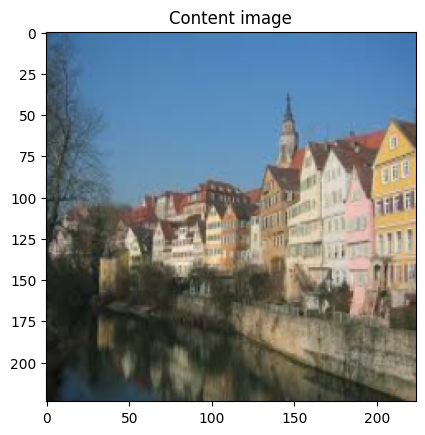

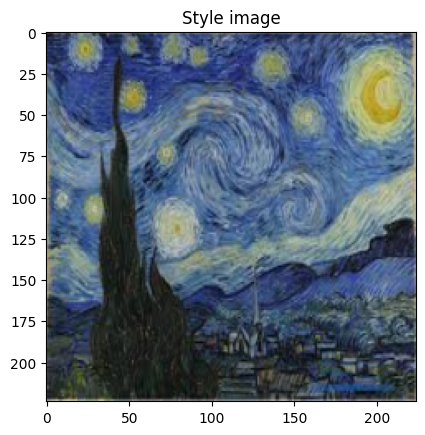

In [5]:
# shape of the output image
imshape = (224, 224)

image_path = "../data/"
content_image_name = "content.jpeg"
style_image_name = "style.jpeg"

content_image = image_loader(image_path + content_image_name)
style_image = image_loader(image_path + style_image_name)

content_height, content_width = content_image.shape[2], content_image.shape[3]
style_height, style_width = style_image.shape[2], style_image.shape[3]

print(f"Content image shape : {content_height} x {content_width}")
print(f"Style image shape : {style_height} x {style_width}")
print(content_image.size())
image_display(content_image, "Content image")
image_display(style_image, "Style image")

### Load the VGG-19 pretrained model 

In [6]:
# importing the VGG 19 model with pre-trained weights
model = models.vgg19(weights=VGG19_Weights.IMAGENET1K_V1).to(device) # move the model to the correct device

<center>
    <h3>Justifying the choice of the layers for content reconstruction</h3>
</center>

In [7]:
content_layers_test = ["conv1_2","conv2_2","conv3_2","conv4_2","conv5_2"]

In [8]:
blocks = [2, 2, 4, 4, 4]  # Number of convolutional layers in each block of the VGG-19 model
renamed_model = nn.Sequential()

# Renommer les couches
index_conv = 0
index_relu = 0
current_block = 0
i = 0

for layer in model.features.eval().children():
    # Vérifier si on doit passer au bloc suivant
    if current_block < len(blocks) and index_conv == blocks[current_block]:
        index_conv = 0  # Réinitialiser le compteur pour le nouveau bloc
        current_block += 1

    if isinstance(layer, nn.Conv2d):  # Pour les couches convolutionnelles
        index_conv += 1
        name = f'conv{current_block + 1}_{index_conv}'
        renamed_model.add_module(name, layer)

    elif isinstance(layer, nn.ReLU):  # Pour les couches ReLU
        index_relu += 1
        name = f'relu{current_block + 1}_{index_relu}'
        renamed_model.add_module(name, nn.ReLU(inplace=False))  # Utiliser inplace=False pour compatibilité

    elif isinstance(layer, nn.MaxPool2d):  # Pour les couches MaxPooling
        name = f'pool{current_block + 1}'
        renamed_model.add_module(name, layer)
    i += 1
# Afficher les premières couches pour vérifier les noms
print(renamed_model)

Sequential(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_1): ReLU()
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_3): ReLU()
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_4): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_5): ReLU()
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_6): ReLU()
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_7): ReLU()
  (conv3_4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4_8): ReLU()
  (pool4): Max

In [9]:
class VGGActivations_content(nn.Module):
    
    def __init__(self, model, target_layers):
        
        super(VGGActivations_content, self).__init__()
        self.model = model
        self.target_layers = target_layers
        self.layer_outputs = {}

    def forward(self, x):
        self.layer_outputs = {}
        for name, layer in self.model.named_children():
            x = layer(x)
            if name in self.target_layers:
                self.layer_outputs[name] = x
        return self.layer_outputs

def reconstruct_image_content(activations_dict):

    # Dictionnary to store the generated images for each layer
    reconstructed_images = {}
    
    for layer, activation in activations_dict.items():
        print(f"{'-'*10}Running optimization for layer : {layer} {'-'*10}")
        # Initialize the random image to optimize
        reconstructed_image = torch.rand_like(input_image, requires_grad=True)

        # Set the optimizer on the image on which we will perform gradient on
        optimizer = torch.optim.Adam([reconstructed_image], lr=0.01)

        # Loop to generate the target image
        for step in range(3000):
            # Reset the gradient to zero
            optimizer.zero_grad()

            # Get the activations of the corresponding layer
            generated_activations = vgg_activations_content(reconstructed_image)

            # Compute the loss
            loss = torch.nn.functional.mse_loss(generated_activations[layer], activations_dict[layer])

            # Backpropagation
            loss.backward()

            # Make a step for the gradient descent
            optimizer.step()

            # Display the loss
            if step % 50 == 0:
                print(f"Step {step} - Loss: {loss.item()}")

        # Store the generated image for the corresponding layer
        reconstructed_images[layer] = reconstructed_image

    return reconstructed_images

# Post-process for visualisation purposes
def deprocess(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    tensor = tensor * std + mean  # Dénormalisation
    return tensor.clamp(0, 1)

In [ ]:
# Prétraitement pour les images VGG
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

input_image = preprocess(torchvision.transforms.functional.to_pil_image(content_image.squeeze(0))).unsqueeze(0)

# Instantiate the new model 
vgg_activations_content = VGGActivations_content(renamed_model, content_layers_test)

# Get the activations at each layer of the list
with torch.no_grad():
    activations_content = vgg_activations_content(input_image)

reconstructed_images_content = reconstruct_image_content(activations_dict = activations_content)

for layer, img in reconstructed_images_content.items():
    
    # Deprocess the image
    output_image = deprocess(img.detach())
    
    # Display the image
    image_display(output_image, layer)

<center>
    <h3>Justifying the choice of the layers for style reconstruction</h3>
</center>

In [10]:
style_layers_test = ["conv1_1","conv2_1","conv3_1","conv4_1","conv4_1"]

In [1]:
class VGGActivations_style(nn.Module):
    
    def __init__(self, model, target_layers):
        
        super(VGGActivations_style, self).__init__()
        self.model = model
        self.target_layers = target_layers
        self.layer_outputs = {}

    def gram_matrix(self, activation):
        """Compute the gram matrix of the activation"""
        a, b, c, d = activation.size()  
        # a = batch size, 
        # b = number of feature maps, 
        # c, d = height, width
        features = activation.view(a * b, c * d)   # flatten the feature maps
        G = torch.mm(features, features.t())  # compute the dot product of the feature maps
        return G.div(a * b * c * d)           # normalize the Gram matrix

    def forward(self, x):
        self.layer_outputs = {}

        # Create a new empty model
        model = nn.Sequential()

        # Initialize key name
        key_name = ""
        
        # Loop over the different combinaisons of layers e.g the number of layers in the list, we add one layer at each iteration
        for i in range(len(self.target_layers)):
            
            # Loop over the layers of the original model
            for name, layer in self.model.named_children():
                
                if name == self.target_layers[i]:

                    if key_name == "":
                        key_name = name
                    else:
                        key_name += f";{name}"
                    model.add_module(name,layer)
                    
            self.layer_outputs[key_name] = self.gram_matrix(model(x))
        
        return self.layer_outputs

def reconstruct_image_style(activations_dict):

    # Dictionnary to store the generated images for each layer
    reconstructed_images = {}
    
    for layer, activation in activations_dict.items():
        print(f"{'-'*10}Running optimization for model with layers : {layer} {'-'*10}")

    
        # Initialize the random image to optimize
        reconstructed_image = torch.rand_like(input_image, requires_grad=True)

        # Set the optimizer on the image on which we will perform gradient on
        optimizer = torch.optim.Adam([reconstructed_image], lr=0.01)

        # Loop to generate the target image
        for step in range(3000):
            # Reset the gradient to zero
            optimizer.zero_grad()

            # Get the activations of the corresponding layer
            generated_activations = vgg_activations_style(reconstructed_image)

            # Compute the loss
            loss = torch.nn.functional.mse_loss(generated_activations[layer], activations_dict[layer])

            # Backpropagation
            loss.backward()

            # Make a step for the gradient descent
            optimizer.step()

            # Display the loss
            if step % 50 == 0:
                print(f"Step {step}, Loss: {loss.item()}")

        # Store the generated image for the corresponding layer
        reconstructed_images[layer] = reconstruct_image

    return reconstructed_images

NameError: name 'nn' is not defined

In [ ]:
# Prétraitement pour les images VGG
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

input_image = preprocess(torchvision.transforms.functional.to_pil_image(style_image.squeeze(0))).unsqueeze(0)

# Instantiate the new model 
vgg_activations_style = VGGActivations_style(renamed_model, style_layers_test)

# Get the activations at each layer of the list
with torch.no_grad():
    activations_style = vgg_activations_style(input_image)

reconstructed_images_style = reconstruct_image_style(activations_dict = activations_style)

for layer, img in reconstructed_images_style.items():
    
    # Deprocess the image
    output_image = deprocess(img.detach())
    
    # Display the image
    image_display(output_image, layer)

torch.Size([64, 64])
Step 0, Loss: 4.293731035431847e-05
